In [1]:
#Projeto Fake-Base-Station-5G
#Criado por Roger W. Coêlho
#Código para Aprendizado de Máquina 
#Validação Cruzada

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
print("Pré-Processamento de Dados: Escolha de Atributos!!!")
print()

#seed
seed = 42

#Tese Roger Base completa
df = pd.read_csv("sctp_FBS_Base.csv", low_memory=False)


#Para a tese do Roger
        
#drop no atributo "Source MAC"
attribute_name_to_remove = 'Source MAC'
df = df.drop(columns = attribute_name_to_remove)

#drop no atributo "Destination MAC"
attribute_name_to_remove = 'Destination MAC'
df = df.drop(columns = attribute_name_to_remove)

#drop no atributo "Source IP"
attribute_name_to_remove = 'Source IP'
df = df.drop(columns = attribute_name_to_remove)

#drop no atributo "Destination IP"
attribute_name_to_remove = 'Destination IP'
df = df.drop(columns = attribute_name_to_remove)

#drop no atributo "Source Port"
attribute_name_to_remove = 'Source Port'
df = df.drop(columns = attribute_name_to_remove)

#drop no atributo "Destination Port"
attribute_name_to_remove = 'Destination Port'
df = df.drop(columns = attribute_name_to_remove)

#drop no atributo "Size"
attribute_name_to_remove = 'Size'
df = df.drop(columns = attribute_name_to_remove)

Pré-Processamento de Dados: Escolha de Atributos!!!



In [3]:
def missing_zero_values_table(df):
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
    mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
    mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[
        mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print ("O dataframe selecionado possui " + str(df.shape[1]) + " colunas e " + str(df.shape[0]) + " linhas.\n"      
        "Há " + str(mz_table.shape[0]) +
        " colunas que possuem valores ausentes.")
    #mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
    return mz_table
    
missing_zero_values_table(df)

O dataframe selecionado possui 25 colunas e 1141564 linhas.
Há 20 colunas que possuem valores ausentes.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Padding,1,1141563,100.0,1141564,100.0,float64
Supported IPs Types,0,1141522,100.0,1141522,100.0,object
N_IN_STREAMS,0,1141472,100.0,1141472,100.0,float64
N_OUT_STREAMS,0,1141472,100.0,1141472,100.0,float64
Data,0,1141472,100.0,1141472,100.0,object
Error Causes,1514,1140042,99.9,1141556,100.0,float64
TBC,10,1140040,99.9,1140050,99.9,float64
TSN,0,711148,62.3,711148,62.3,float64
A_RWND,0,711058,62.3,711058,62.3,float64
Flags,431916,709648,62.2,1141564,100.0,float64


In [4]:
set(df.columns[df.isnull().mean()==0])

{'Checksum', 'Label', 'Protocol', 'Type', 'Verification Tag'}

In [5]:
#Nome das colunas que possuem valores em falta
df.columns[df.isnull().any()]

print(df.shape)

# drop columns with all NaN's
df = df.dropna(axis=1, how='any')

print(df.shape)

print(df.shape)
df.drop(df.columns[df.isnull().any()], axis=1)
print(df.shape)

print(df.shape)
#df = df.dropna()
    
df.shape

attribute_target = 'Label'
df[attribute_target] = df[attribute_target].replace(['Normal', 'Attack'], [0.0,1.0])

df.Label

#target
target = df["Label"]

df.to_csv('ataqueTeste.csv', index=False)

# getting scaled train data
dataset = df.drop("Label", axis=1)
#scaled_train = StandardScaler().fit_transform(train) Excluir

## Normalizando com MinMaxScaler
scaler = MinMaxScaler()

# Verificando se a coluna 'Checksum' existe no dataset
dataset_normalized = dataset.copy()  # Criar uma cópia dos dados para a versão normalizada
dataset_normalized[['Verification Tag', 'Checksum']] = scaler.fit_transform(dataset[['Verification Tag', 'Checksum']])

# Definir os dados de entrada (X) e os rótulos de saída (y)
X = dataset  # Versão sem a coluna normalizada
X_normalized = dataset_normalized  # Versão com a coluna normalizada
y = target

# Definir a validação cruzada com 10 folds
kfold = 10

df.dtypes

(1141564, 25)
(1141564, 5)
(1141564, 5)
(1141564, 5)
(1141564, 5)


C:\Users\Roger Coêlho\AppData\Local\Temp\ipykernel_13048\2079079094.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[attribute_target] = df[attribute_target].replace(['Normal', 'Attack'], [0.0,1.0])


Verification Tag      int64
Checksum              int64
Type                  int64
Protocol              int64
Label               float64
dtype: object

In [6]:
# Construindo todos os Modelos
model_1 = RandomForestClassifier(random_state=seed)
model_2 = DecisionTreeClassifier(random_state=seed)
model_3 = SGDClassifier(random_state=seed, max_iter=40000000)
model_4 = LogisticRegression(random_state=seed)
model_5 = KNeighborsClassifier(n_neighbors = 5000)
model_6 = GaussianNB()
model_7 = XGBClassifier(random_state=seed)
model_8 = Perceptron(tol=1e-3, random_state=seed)
model_9 = MLPClassifier(random_state=seed,max_iter=1000)

# Variável para imprimir os scores de todas as médias dos scores e desvio padrão
resultado = []

In [7]:
#Modelo de Random Forest
print("Modelo Random Forest")
print()

# Realizar a validação cruzada para obter os scores de acurácia
scores = cross_val_score(model_1, X, y, cv=kfold)

# Imprimir os scores de cada fold e a média dos scores
print("Scores de cada fold:")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: ", round(score * 100 , 2))
print(f"\nMédia dos scores: {round(scores.mean() * 100, 2)}")

resultado.append(("Modelo Random Forest", round(scores.mean() * 100, 2), "{:.2e}".format(scores.std())))
print()

# Construção de um DataFrame para os resultados
print("Resultado da Média da Acurácia e do Desvio Padrão")
resultados_df = pd.DataFrame([resultado[0]], columns=['Model', 'Mean Accuracy', 'Standard Deviation'])

print(resultados_df)

print()

# Obter previsões usando cross_val_predict
pred_1 = cross_val_predict(model_1, X, y, cv=kfold)

# Calcular as métricas
precision = precision_score(y, pred_1, average='weighted')
recall = recall_score(y, pred_1, average='weighted')
f1 = f1_score(y, pred_1, average='weighted')
all_results = precision_recall_fscore_support(y, pred_1, average='weighted')

print("Métricas weighted avg")
print("Precision (weighted avg):", round(precision * 100, 2))
print("Recall (weighted avg):", round(recall * 100, 2))
print("F1 Score (weighted avg):", round(f1 * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Macro Average
precision_macro = precision_score(y, pred_1, average='macro')
recall_macro = recall_score(y, pred_1, average='macro')
f1_macro = f1_score(y, pred_1, average='macro')
all_results = precision_recall_fscore_support(y, pred_1, average='macro')

print("Métricas macro avg")
print("Precision (macro avg):", round(precision_macro * 100, 2))
print("Recall (macro avg):", round(recall_macro * 100, 2))
print("F1 Score (macro avg):", round(f1_macro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Micro Average
precision_micro = precision_score(y, pred_1, average='micro')
recall_micro = recall_score(y, pred_1, average='micro')
f1_micro = f1_score(y, pred_1, average='micro')
all_results = precision_recall_fscore_support(y, pred_1, average='micro')

print("Métricas micro avg")
print("Precision (micro avg):", round(precision_micro * 100, 2))
print("Recall (micro avg):", round(recall_micro * 100, 2))
print("F1 Score (micro avg):", round(f1_micro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

#Classification Report, Accuracy e AUC
report = classification_report(y, pred_1)
accuracy = round(accuracy_score(y, pred_1) * 100, 2)
auc = round(roc_auc_score(y, pred_1), 2) if len(np.unique(y)) > 1 else None  # Verificar se há mais de uma classe para AUC

print("Modelo Random Forest")
print(report)
print(f" Accuracy: {accuracy}%")
print(f" AUC score: {auc}")

correct1 = accuracy

Modelo Random Forest

Scores de cada fold:
Fold 1:  99.99
Fold 2:  99.71
Fold 3:  100.0
Fold 4:  99.99
Fold 5:  100.0
Fold 6:  99.99
Fold 7:  100.0
Fold 8:  99.99
Fold 9:  100.0
Fold 10:  100.0

Média dos scores: 99.97

Resultado da Média da Acurácia e do Desvio Padrão
                  Model  Mean Accuracy Standard Deviation
0  Modelo Random Forest          99.97           8.62e-04

Métricas weighted avg
Precision (weighted avg): 99.97
Recall (weighted avg): 99.97
F1 Score (weighted avg): 99.97
Todos os Resultados:  (0.9996760840420916, 0.9996758832619108, 0.9996758883602169, None)

Métricas macro avg
Precision (macro avg): 99.97
Recall (macro avg): 99.97
F1 Score (macro avg): 99.97
Todos os Resultados:  (0.9996594181462992, 0.9996908573994332, 0.9996750419834698, None)

Métricas micro avg
Precision (micro avg): 99.97
Recall (micro avg): 99.97
F1 Score (micro avg): 99.97
Todos os Resultados:  (0.9996758832619108, 0.9996758832619108, 0.9996758832619108, None)

Modelo Random Forest
    

Matriz de Confusão Modelo Random Forest


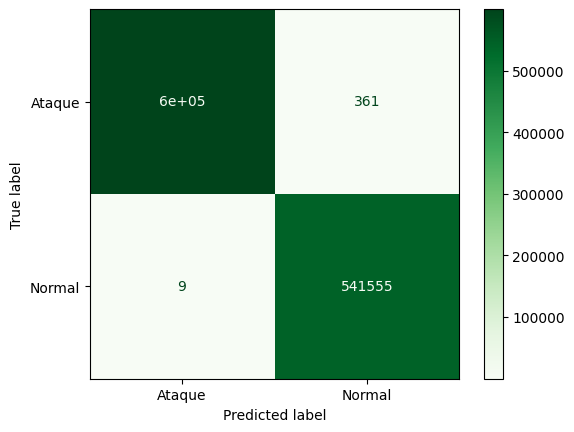

In [8]:
#Matriz de Confusão Modelo Random Forest
print("Matriz de Confusão Modelo Random Forest")
labels = ['Normal', 'Ataque']
cm = confusion_matrix(y, pred_1)
cm_inverted = cm.copy()
cm_inverted[0, 0], cm_inverted[1, 1] = cm[1, 1], cm[0, 0] 
cm_inverted[0, 1], cm_inverted[1, 0] = cm[1, 0], cm[0, 1]  
inverted_labels = labels[::-1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_inverted, display_labels=inverted_labels)
disp.plot(cmap=plt.cm.Greens)
plt.grid(False)
plt.show()

In [9]:
# Inicializar o modelo de árvore de decisão
print("Modelo Decision Tree")
print()

# Realizar a validação cruzada para obter os scores de acurácia
scores = cross_val_score(model_2, X, y, cv=kfold)

# Imprimir os scores de cada fold e a média dos scores
print("Scores de cada fold:")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: ", round(score * 100 , 2))
print(f"\nMédia dos scores: {round(scores.mean() * 100, 2)}")

resultado.append(("Modelo Decision Tree", round(scores.mean() * 100, 2), "{:.2e}".format(scores.std())))
print()

# Construção de um DataFrame para os resultados
print("Resultado da Média da Acurácia e do Desvio Padrão")
resultados_df = pd.DataFrame([resultado[1]], columns=['Model', 'Mean Accuracy', 'Standard Deviation'])

print(resultados_df)

print()

# Obter previsões usando cross_val_predict
pred_2 = cross_val_predict(model_2, X, y, cv=kfold)

# Calcular as métricas
precision = precision_score(y, pred_2, average='weighted')
recall = recall_score(y, pred_2, average='weighted')
f1 = f1_score(y, pred_2, average='weighted')
all_results = precision_recall_fscore_support(y, pred_2, average='weighted')

print("Métricas weighted avg")
print("Precision (weighted avg):", round(precision * 100, 2))
print("Recall (weighted avg):", round(recall * 100, 2))
print("F1 Score (weighted avg):", round(f1 * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Macro Average
precision_macro = precision_score(y, pred_2, average='macro')
recall_macro = recall_score(y, pred_2, average='macro')
f1_macro = f1_score(y, pred_2, average='macro')
all_results = precision_recall_fscore_support(y, pred_2, average='macro')

print("Métricas macro avg")
print("Precision (macro avg):", round(precision_macro * 100, 2))
print("Recall (macro avg):", round(recall_macro * 100, 2))
print("F1 Score (macro avg):", round(f1_macro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Micro Average
precision_micro = precision_score(y, pred_2, average='micro')
recall_micro = recall_score(y, pred_2, average='micro')
f1_micro = f1_score(y, pred_2, average='micro')
all_results = precision_recall_fscore_support(y, pred_2, average='micro')

print("Métricas micro avg")
print("Precision (micro avg):", round(precision_micro * 100, 2))
print("Recall (micro avg):", round(recall_micro * 100, 2))
print("F1 Score (micro avg):", round(f1_micro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

#Classification Report, Accuracy e AUC
report = classification_report(y, pred_2)
accuracy = round(accuracy_score(y, pred_2) * 100, 2)
auc = round(roc_auc_score(y, pred_2), 2) if len(np.unique(y)) > 1 else None  # Verificar se há mais de uma classe para AUC

print("Modelo Decision Tree")
print(report)
print(f" Accuracy: {accuracy}%")
print(f" AUC score: {auc}")

correct2 = accuracy

Modelo Decision Tree

Scores de cada fold:
Fold 1:  100.0
Fold 2:  99.71
Fold 3:  100.0
Fold 4:  100.0
Fold 5:  100.0
Fold 6:  100.0
Fold 7:  100.0
Fold 8:  99.99
Fold 9:  100.0
Fold 10:  100.0

Média dos scores: 99.97

Resultado da Média da Acurácia e do Desvio Padrão
                  Model  Mean Accuracy Standard Deviation
0  Modelo Decision Tree          99.97           8.69e-04

Métricas weighted avg
Precision (weighted avg): 99.97
Recall (weighted avg): 99.97
F1 Score (weighted avg): 99.97
Todos os Resultados:  (0.999698850322163, 0.9996986590326955, 0.9996986636656552, None)

Métricas macro avg
Precision (macro avg): 99.97
Recall (macro avg): 99.97
F1 Score (macro avg): 99.97
Todos os Resultados:  (0.9996826029510544, 0.9997133333333333, 0.999697876655087, None)

Métricas micro avg
Precision (micro avg): 99.97
Recall (micro avg): 99.97
F1 Score (micro avg): 99.97
Todos os Resultados:  (0.9996986590326955, 0.9996986590326955, 0.9996986590326955, None)

Modelo Decision Tree
      

Matriz de Confusão Modelo Decision Tree


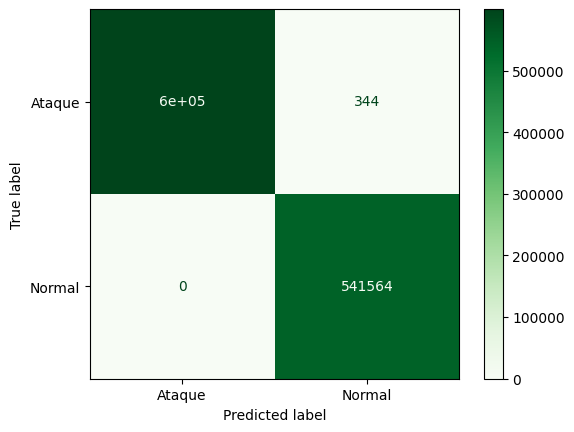

In [10]:
#Matriz de Confusão Modelo Decision Tree
print("Matriz de Confusão Modelo Decision Tree")
labels = ['Normal', 'Ataque']
cm = confusion_matrix(y, pred_2) 
cm_inverted = cm.copy()
cm_inverted[0, 0], cm_inverted[1, 1] = cm[1, 1], cm[0, 0]  
cm_inverted[0, 1], cm_inverted[1, 0] = cm[1, 0], cm[0, 1]  
inverted_labels = labels[::-1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_inverted, display_labels=inverted_labels)
disp.plot(cmap=plt.cm.Greens)
plt.grid(False)
plt.show()

In [11]:
#Modelo SGD Classifier
print("Modelo SGD Classifier")
print()

# Realizar a validação cruzada para obter os scores de acurácia
scores = cross_val_score(model_3, X, y, cv=kfold)

# Imprimir os scores de cada fold e a média dos scores
print("Scores de cada fold:")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: ", round(score * 100 , 2))
print(f"\nMédia dos scores: {round(scores.mean() * 100, 2)}")

resultado.append(("Modelo SGD Classifier", round(scores.mean() * 100, 2), "{:.2e}".format(scores.std())))
print()

# Construção de um DataFrame para os resultados
print("Resultado da Média da Acurácia e do Desvio Padrão")
resultados_df = pd.DataFrame([resultado[2]], columns=['Model', 'Mean Accuracy', 'Standard Deviation'])

print(resultados_df)

print()

# Obter previsões usando cross_val_predict
pred_3 = cross_val_predict(model_3, X, y, cv=kfold)

# Calcular as métricas
precision = precision_score(y, pred_3, average='weighted')
recall = recall_score(y, pred_3, average='weighted')
f1 = f1_score(y, pred_3, average='weighted')
all_results = precision_recall_fscore_support(y, pred_3, average='weighted')

print("Métricas weighted avg")
print("Precision (weighted avg):", round(precision * 100, 2))
print("Recall (weighted avg):", round(recall * 100, 2))
print("F1 Score (weighted avg):", round(f1 * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Macro Average
precision_macro = precision_score(y, pred_3, average='macro')
recall_macro = recall_score(y, pred_3, average='macro')
f1_macro = f1_score(y, pred_3, average='macro')
all_results = precision_recall_fscore_support(y, pred_3, average='macro')

print("Métricas macro avg")
print("Precision (macro avg):", round(precision_macro * 100, 2))
print("Recall (macro avg):", round(recall_macro * 100, 2))
print("F1 Score (macro avg):", round(f1_macro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Micro Average
precision_micro = precision_score(y, pred_3, average='micro')
recall_micro = recall_score(y, pred_3, average='micro')
f1_micro = f1_score(y, pred_3, average='micro')
all_results = precision_recall_fscore_support(y, pred_3, average='micro')

print("Métricas micro avg")
print("Precision (micro avg):", round(precision_micro * 100, 2))
print("Recall (micro avg):", round(recall_micro * 100, 2))
print("F1 Score (micro avg):", round(f1_micro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

#Classification Report, Accuracy e AUC
report = classification_report(y, pred_3)
accuracy = round(accuracy_score(y, pred_3) * 100, 2)
auc = round(roc_auc_score(y, pred_3), 2) if len(np.unique(y)) > 1 else None  # Verificar se há mais de uma classe para AUC

print("Modelo SGD Classifier")
print(report)
print(f" Accuracy: {accuracy}%")
print(f" AUC score: {auc}")

correct3 = accuracy

Modelo SGD Classifier

Scores de cada fold:
Fold 1:  51.64
Fold 2:  47.44
Fold 3:  36.65
Fold 4:  58.14
Fold 5:  46.31
Fold 6:  47.44
Fold 7:  52.36
Fold 8:  52.56
Fold 9:  52.56
Fold 10:  49.88

Média dos scores: 49.5

Resultado da Média da Acurácia e do Desvio Padrão
                   Model  Mean Accuracy Standard Deviation
0  Modelo SGD Classifier           49.5           5.39e-02

Métricas weighted avg
Precision (weighted avg): 49.71
Recall (weighted avg): 49.5
F1 Score (weighted avg): 49.52
Todos os Resultados:  (0.49708627726297233, 0.49497093461251407, 0.4951733534514214, None)

Métricas macro avg
Precision (macro avg): 49.58
Recall (macro avg): 49.58
F1 Score (macro avg): 49.49
Todos os Resultados:  (0.4957829838913786, 0.49577620593318605, 0.4949239270703323, None)

Métricas micro avg
Precision (micro avg): 49.5
Recall (micro avg): 49.5
F1 Score (micro avg): 49.5
Todos os Resultados:  (0.49497093461251407, 0.49497093461251407, 0.49497093461251407, None)

Modelo SGD Classifier

Matriz de Confusão Modelo SGD Classifier


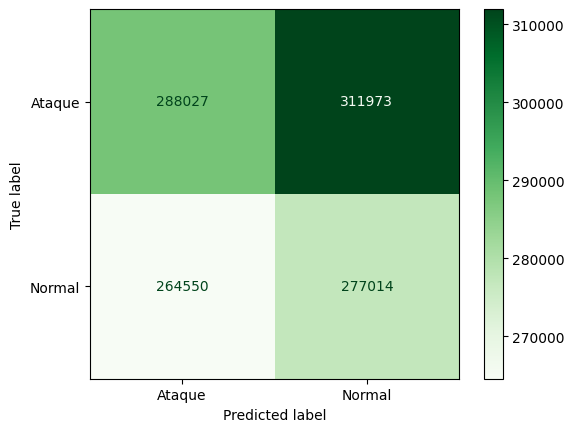

In [12]:
#Matriz de Confusão Modelo SGD Classifier
print("Matriz de Confusão Modelo SGD Classifier")
labels = ['Normal', 'Ataque']
cm = confusion_matrix(y, pred_3)
cm_inverted = cm.copy()
cm_inverted[0, 0], cm_inverted[1, 1] = cm[1, 1], cm[0, 0]  
cm_inverted[0, 1], cm_inverted[1, 0] = cm[1, 0], cm[0, 1]  
inverted_labels = labels[::-1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_inverted, display_labels=inverted_labels)
disp.plot(cmap=plt.cm.Greens)
plt.grid(False)
plt.show()

In [13]:
#Modelo Logistic Regression
print("Modelo Logistic Regression")
print()

# Realizar a validação cruzada para obter os scores de acurácia
scores = cross_val_score(model_4, X_normalized, y, cv=kfold)

# Imprimir os scores de cada fold e a média dos scores
print("Scores de cada fold:")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: ", round(score * 100 , 2))
print(f"\nMédia dos scores: {round(scores.mean() * 100, 2)}")

resultado.append(("Modelo Logistic Regression", round(scores.mean() * 100, 2), "{:.2e}".format(scores.std())))
print()

# Construção de um DataFrame para os resultados
print("Resultado da Média da Acurácia e do Desvio Padrão")
resultados_df = pd.DataFrame([resultado[3]], columns=['Model', 'Mean Accuracy', 'Standard Deviation'])

print(resultados_df)

print()

# Obter previsões usando cross_val_predict
pred_4 = cross_val_predict(model_4, X_normalized, y, cv=kfold)

# Calcular as métricas
precision = precision_score(y, pred_4, average='weighted')
recall = recall_score(y, pred_4, average='weighted')
f1 = f1_score(y, pred_4, average='weighted')
all_results = precision_recall_fscore_support(y, pred_4, average='weighted')

print("Métricas weighted avg")
print("Precision (weighted avg):", round(precision * 100, 2))
print("Recall (weighted avg):", round(recall * 100, 2))
print("F1 Score (weighted avg):", round(f1 * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Macro Average
precision_macro = precision_score(y, pred_4, average='macro')
recall_macro = recall_score(y, pred_4, average='macro')
f1_macro = f1_score(y, pred_4, average='macro')
all_results = precision_recall_fscore_support(y, pred_4, average='macro')

print("Métricas macro avg")
print("Precision (macro avg):", round(precision_macro * 100, 2))
print("Recall (macro avg):", round(recall_macro * 100, 2))
print("F1 Score (macro avg):", round(f1_macro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Micro Average
precision_micro = precision_score(y, pred_4, average='micro')
recall_micro = recall_score(y, pred_4, average='micro')
f1_micro = f1_score(y, pred_4, average='micro')
all_results = precision_recall_fscore_support(y, pred_4, average='micro')

print("Métricas micro avg")
print("Precision (micro avg):", round(precision_micro * 100, 2))
print("Recall (micro avg):", round(recall_micro * 100, 2))
print("F1 Score (micro avg):", round(f1_micro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

#Classification Report, Accuracy e AUC
report = classification_report(y, pred_4)
accuracy = round(accuracy_score(y, pred_4) * 100, 2)
auc = round(roc_auc_score(y, pred_4), 2) if len(np.unique(y)) > 1 else None  # Verificar se há mais de uma classe para AUC

print("Modelo Logist Regression")
print(report)
print(f" Accuracy: {accuracy}%")
print(f" AUC score: {auc}")

correct4 = accuracy

Modelo Logistic Regression

Scores de cada fold:
Fold 1:  53.94
Fold 2:  73.38
Fold 3:  42.43
Fold 4:  57.33
Fold 5:  59.85
Fold 6:  33.02
Fold 7:  54.03
Fold 8:  68.71
Fold 9:  88.8
Fold 10:  64.04

Média dos scores: 59.55

Resultado da Média da Acurácia e do Desvio Padrão
                        Model  Mean Accuracy Standard Deviation
0  Modelo Logistic Regression          59.55           1.49e-01

Métricas weighted avg
Precision (weighted avg): 59.56
Recall (weighted avg): 59.55
F1 Score (weighted avg): 59.56
Todos os Resultados:  (0.5956167664054905, 0.5955136987501358, 0.5955617222227659, None)

Métricas macro avg
Precision (macro avg): 59.45
Recall (macro avg): 59.46
F1 Score (macro avg): 59.45
Todos os Resultados:  (0.5945307834432998, 0.5945756878226766, 0.5945497136953173, None)

Métricas micro avg
Precision (micro avg): 59.55
Recall (micro avg): 59.55
F1 Score (micro avg): 59.55
Todos os Resultados:  (0.5955136987501358, 0.5955136987501358, 0.5955136987501358, None)

Modelo L

Matriz de Confusão Modelo Logistic Regression


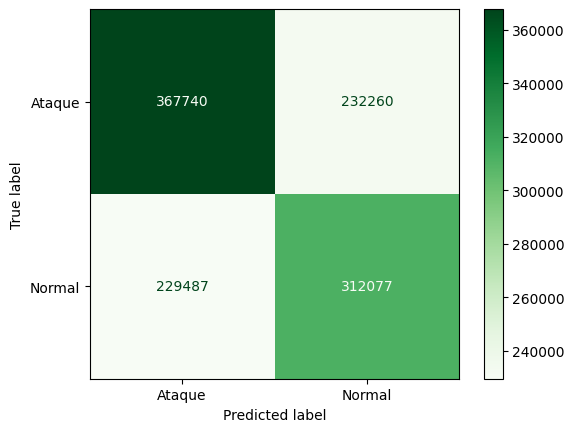

In [14]:
#Matriz de Confusão Modelo Logistic Regression
print("Matriz de Confusão Modelo Logistic Regression")
labels = ['Normal', 'Ataque']
cm = confusion_matrix(y, pred_4)
cm_inverted = cm.copy()
cm_inverted[0, 0], cm_inverted[1, 1] = cm[1, 1], cm[0, 0]  
cm_inverted[0, 1], cm_inverted[1, 0] = cm[1, 0], cm[0, 1]  
inverted_labels = labels[::-1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_inverted, display_labels=inverted_labels)
disp.plot(cmap=plt.cm.Greens)
plt.grid(False)
plt.show()

In [15]:
#Modelo K-NN Vizinhos mais próximos
print("Modelo K-NN")
print()

# Realizar a validação cruzada para obter os scores de acurácia
scores = cross_val_score(model_5, X_normalized, y, cv=kfold)

# Imprimir os scores de cada fold e a média dos scores
print("Scores de cada fold:")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: ", round(score * 100 , 2))
print(f"\nMédia dos scores: {round(scores.mean() * 100, 2)}")

resultado.append(("Modelo K-NN", round(scores.mean() * 100, 2), "{:.2e}".format(scores.std())))
print()

# Construção de um DataFrame para os resultados
print("Resultado da Média da Acurácia e do Desvio Padrão")
resultados_df = pd.DataFrame([resultado[4]], columns=['Model', 'Mean Accuracy', 'Standard Deviation'])

print(resultados_df)

print()

# Obter previsões usando cross_val_predict
pred_5 = cross_val_predict(model_5, X_normalized, y, cv=kfold)

# Calcular as métricas
precision = precision_score(y, pred_5, average='weighted')
recall = recall_score(y, pred_5, average='weighted')
f1 = f1_score(y, pred_5, average='weighted')
all_results = precision_recall_fscore_support(y, pred_5, average='weighted')

print("Métricas weighted avg")
print("Precision (weighted avg):", round(precision * 100, 2))
print("Recall (weighted avg):", round(recall * 100, 2))
print("F1 Score (weighted avg):", round(f1 * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Macro Average
precision_macro = precision_score(y, pred_5, average='macro')
recall_macro = recall_score(y, pred_5, average='macro')
f1_macro = f1_score(y, pred_5, average='macro')
all_results = precision_recall_fscore_support(y, pred_5, average='macro')

print("Métricas macro avg")
print("Precision (macro avg):", round(precision_macro * 100, 2))
print("Recall (macro avg):", round(recall_macro * 100, 2))
print("F1 Score (macro avg):", round(f1_macro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Micro Average
precision_micro = precision_score(y, pred_5, average='micro')
recall_micro = recall_score(y, pred_5, average='micro')
f1_micro = f1_score(y, pred_5, average='micro')
all_results = precision_recall_fscore_support(y, pred_5, average='micro')

print("Métricas micro avg")
print("Precision (micro avg):", round(precision_micro * 100, 2))
print("Recall (micro avg):", round(recall_micro * 100, 2))
print("F1 Score (micro avg):", round(f1_micro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

#Classification Report, Accuracy e AUC
report = classification_report(y, pred_5)
accuracy = round(accuracy_score(y, pred_5) * 100, 2)
auc = round(roc_auc_score(y, pred_5), 2) if len(np.unique(y)) > 1 else None  # Verificar se há mais de uma classe para AUC

print("Modelo K-NN")
print(report)
print(f" Accuracy: {accuracy}%")
print(f" AUC score: {auc}")

correct5 = accuracy

Modelo K-NN

Scores de cada fold:
Fold 1:  91.53
Fold 2:  68.06
Fold 3:  88.15
Fold 4:  99.99
Fold 5:  79.04
Fold 6:  86.61
Fold 7:  88.61
Fold 8:  92.2
Fold 9:  71.55
Fold 10:  100.0

Média dos scores: 86.57

Resultado da Média da Acurácia e do Desvio Padrão
         Model  Mean Accuracy Standard Deviation
0  Modelo K-NN          86.57           1.02e-01

Métricas weighted avg
Precision (weighted avg): 87.93
Recall (weighted avg): 86.57
F1 Score (weighted avg): 86.37
Todos os Resultados:  (0.8792524398693473, 0.8657412111804507, 0.8637357140030193, None)

Métricas macro avg
Precision (macro avg): 88.28
Recall (macro avg): 86.04
F1 Score (macro avg): 86.27
Todos os Resultados:  (0.8827833923467602, 0.8603618973873202, 0.8626875021208658, None)

Métricas micro avg
Precision (micro avg): 86.57
Recall (micro avg): 86.57
F1 Score (micro avg): 86.57
Todos os Resultados:  (0.8657412111804507, 0.8657412111804507, 0.8657412111804507, None)

Modelo K-NN
              precision    recall  f1-sco

Matriz de Confusão Modelo K-NN


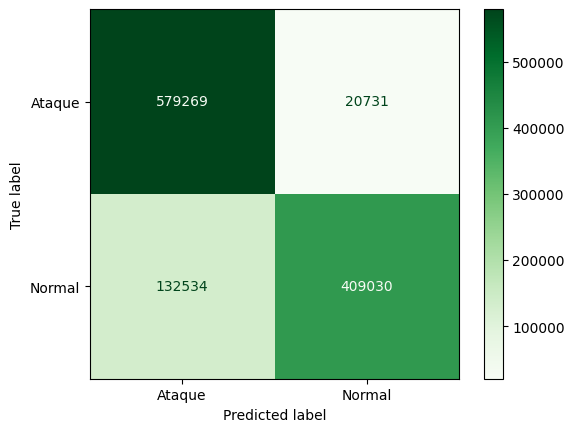

In [16]:
#Matriz de Confusão Modelo K-NN
print("Matriz de Confusão Modelo K-NN")
labels = ['Normal', 'Ataque']
cm = confusion_matrix(y, pred_5)
cm_inverted = cm.copy()
cm_inverted[0, 0], cm_inverted[1, 1] = cm[1, 1], cm[0, 0]  
cm_inverted[0, 1], cm_inverted[1, 0] = cm[1, 0], cm[0, 1]  
inverted_labels = labels[::-1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_inverted, display_labels=inverted_labels)
disp.plot(cmap=plt.cm.Greens)
plt.grid(False)
plt.show()

In [17]:
#Modelo Naive Bayes
print("Modelo Naive Bayes")
print()

# Realizar a validação cruzada para obter os scores de acurácia
scores = cross_val_score(model_6, X, y, cv=kfold)

# Imprimir os scores de cada fold e a média dos scores
print("Scores de cada fold:")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: ", round(score * 100 , 2))
print(f"\nMédia dos scores: {round(scores.mean() * 100, 2)}")

resultado.append(("Modelo Naive Bayes", round(scores.mean() * 100, 2), "{:.2e}".format(scores.std())))
print()

# Construção de um DataFrame para os resultados
print("Resultado da Média da Acurácia e do Desvio Padrão")
resultados_df = pd.DataFrame([resultado[5]], columns=['Model', 'Mean Accuracy', 'Standard Deviation'])

print(resultados_df)

print()

# Obter previsões usando cross_val_predict
pred_6 = cross_val_predict(model_6, X, y, cv=kfold)

# Calcular as métricas
precision = precision_score(y, pred_6, average='weighted')
recall = recall_score(y, pred_6, average='weighted')
f1 = f1_score(y, pred_6, average='weighted')
all_results = precision_recall_fscore_support(y, pred_6, average='weighted')

print("Métricas weighted avg")
print("Precision (weighted avg):", round(precision * 100, 2))
print("Recall (weighted avg):", round(recall * 100, 2))
print("F1 Score (weighted avg):", round(f1 * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Macro Average
precision_macro = precision_score(y, pred_6, average='macro')
recall_macro = recall_score(y, pred_6, average='macro')
f1_macro = f1_score(y, pred_6, average='macro')
all_results = precision_recall_fscore_support(y, pred_6, average='macro')

print("Métricas macro avg")
print("Precision (macro avg):", round(precision_macro * 100, 2))
print("Recall (macro avg):", round(recall_macro * 100, 2))
print("F1 Score (macro avg):", round(f1_macro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Micro Average
precision_micro = precision_score(y, pred_6, average='micro')
recall_micro = recall_score(y, pred_6, average='micro')
f1_micro = f1_score(y, pred_6, average='micro')
all_results = precision_recall_fscore_support(y, pred_6, average='micro')

print("Métricas micro avg")
print("Precision (micro avg):", round(precision_micro * 100, 2))
print("Recall (micro avg):", round(recall_micro * 100, 2))
print("F1 Score (micro avg):", round(f1_micro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

#Classification Report, Accuracy e AUC
report = classification_report(y, pred_6)
accuracy = round(accuracy_score(y, pred_6) * 100, 2)
auc = round(roc_auc_score(y, pred_6), 2) if len(np.unique(y)) > 1 else None  # Verificar se há mais de uma classe para AUC

print("Modelo Naive Bayes")
print(report)
print(f" Accuracy: {accuracy}%")
print(f" AUC score: {auc}")

correct6 = accuracy

Modelo Naive Bayes

Scores de cada fold:
Fold 1:  60.92
Fold 2:  84.35
Fold 3:  57.24
Fold 4:  68.15
Fold 5:  59.88
Fold 6:  33.02
Fold 7:  54.06
Fold 8:  69.46
Fold 9:  94.13
Fold 10:  62.32

Média dos scores: 64.35

Resultado da Média da Acurácia e do Desvio Padrão
                Model  Mean Accuracy Standard Deviation
0  Modelo Naive Bayes          64.35           1.58e-01

Métricas weighted avg
Precision (weighted avg): 64.69
Recall (weighted avg): 64.35
F1 Score (weighted avg): 64.35
Todos os Resultados:  (0.6469006527303451, 0.6435337834760031, 0.6435365406032086, None)

Métricas macro avg
Precision (macro avg): 64.52
Recall (macro avg): 64.52
F1 Score (macro avg): 64.35
Todos os Resultados:  (0.6452122194901522, 0.6452167239329054, 0.6435337752892807, None)

Métricas micro avg
Precision (micro avg): 64.35
Recall (micro avg): 64.35
F1 Score (micro avg): 64.35
Todos os Resultados:  (0.6435337834760031, 0.6435337834760031, 0.6435337834760031, None)

Modelo Naive Bayes
            

Matriz de Confusão Modelo Naive Bayes


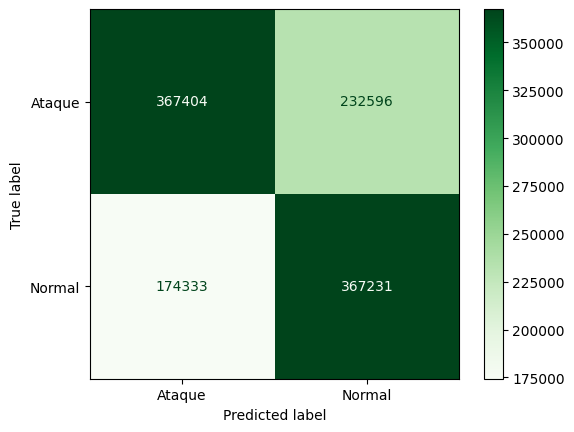

In [18]:
#Matriz de Confusão Modelo Naive Bayes
print("Matriz de Confusão Modelo Naive Bayes")
labels = ['Normal', 'Ataque']
cm = confusion_matrix(y, pred_6)
cm_inverted = cm.copy()
cm_inverted[0, 0], cm_inverted[1, 1] = cm[1, 1], cm[0, 0]  
cm_inverted[0, 1], cm_inverted[1, 0] = cm[1, 0], cm[0, 1]  
inverted_labels = labels[::-1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_inverted, display_labels=inverted_labels)
disp.plot(cmap=plt.cm.Greens)
plt.grid(False)
plt.show()

In [19]:
#Modelo XGB Classifier
print("Modelo XGB Classifier")
print()

# Realizar a validação cruzada para obter os scores de acurácia
scores = cross_val_score(model_7, X, y, cv=kfold)

# Imprimir os scores de cada fold e a média dos scores
print("Scores de cada fold:")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: ", round(score * 100 , 2))
print(f"\nMédia dos scores: {round(scores.mean() * 100, 2)}")

resultado.append(("Modelo XGB Classifier", round(scores.mean() * 100, 2), "{:.2e}".format(scores.std())))
print()

# Construção de um DataFrame para os resultados
print("Resultado da Média da Acurácia e do Desvio Padrão")
resultados_df = pd.DataFrame([resultado[6]], columns=['Model', 'Mean Accuracy', 'Standard Deviation'])

print(resultados_df)

print()

# Obter previsões usando cross_val_predict
pred_7 = cross_val_predict(model_7, X, y, cv=kfold)

# Calcular as métricas
precision = precision_score(y, pred_7, average='weighted')
recall = recall_score(y, pred_7, average='weighted')
f1 = f1_score(y, pred_7, average='weighted')
all_results = precision_recall_fscore_support(y, pred_7, average='weighted')

print("Métricas weighted avg")
print("Precision (weighted avg):", round(precision * 100, 2))
print("Recall (weighted avg):", round(recall * 100, 2))
print("F1 Score (weighted avg):", round(f1 * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Macro Average
precision_macro = precision_score(y, pred_7, average='macro')
recall_macro = recall_score(y, pred_7, average='macro')
f1_macro = f1_score(y, pred_7, average='macro')
all_results = precision_recall_fscore_support(y, pred_7, average='macro')

print("Métricas macro avg")
print("Precision (macro avg):", round(precision_macro * 100, 2))
print("Recall (macro avg):", round(recall_macro * 100, 2))
print("F1 Score (macro avg):", round(f1_macro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Micro Average
precision_micro = precision_score(y, pred_7, average='micro')
recall_micro = recall_score(y, pred_7, average='micro')
f1_micro = f1_score(y, pred_7, average='micro')
all_results = precision_recall_fscore_support(y, pred_7, average='micro')

print("Métricas micro avg")
print("Precision (micro avg):", round(precision_micro * 100, 2))
print("Recall (micro avg):", round(recall_micro * 100, 2))
print("F1 Score (micro avg):", round(f1_micro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

#Classification Report, Accuracy e AUC
report = classification_report(y, pred_7)
accuracy = round(accuracy_score(y, pred_7) * 100, 2)
auc = round(roc_auc_score(y, pred_7), 2) if len(np.unique(y)) > 1 else None  # Verificar se há mais de uma classe para AUC

print("Modelo XGB Classifier")
print(report)
print(f" Accuracy: {accuracy}%")
print(f" AUC score: {auc}")

correct7 = accuracy

Modelo XGB Classifier

Scores de cada fold:
Fold 1:  100.0
Fold 2:  100.0
Fold 3:  100.0
Fold 4:  100.0
Fold 5:  100.0
Fold 6:  100.0
Fold 7:  100.0
Fold 8:  100.0
Fold 9:  100.0
Fold 10:  100.0

Média dos scores: 100.0

Resultado da Média da Acurácia e do Desvio Padrão
                   Model  Mean Accuracy Standard Deviation
0  Modelo XGB Classifier          100.0           1.67e-05

Métricas weighted avg
Precision (weighted avg): 100.0
Recall (weighted avg): 100.0
F1 Score (weighted avg): 100.0
Todos os Resultados:  (0.9999859842496153, 0.9999859841410556, 0.999985984146096, None)

Métricas macro avg
Precision (macro avg): 100.0
Recall (macro avg): 100.0
F1 Score (macro avg): 100.0
Todos os Resultados:  (0.9999855877629009, 0.9999863069923407, 0.9999859473281228, None)

Métricas micro avg
Precision (micro avg): 100.0
Recall (micro avg): 100.0
F1 Score (micro avg): 100.0
Todos os Resultados:  (0.9999859841410556, 0.9999859841410556, 0.9999859841410556, None)

Modelo XGB Classifier
 

Matriz de Confusão Modelo XGB Classifier


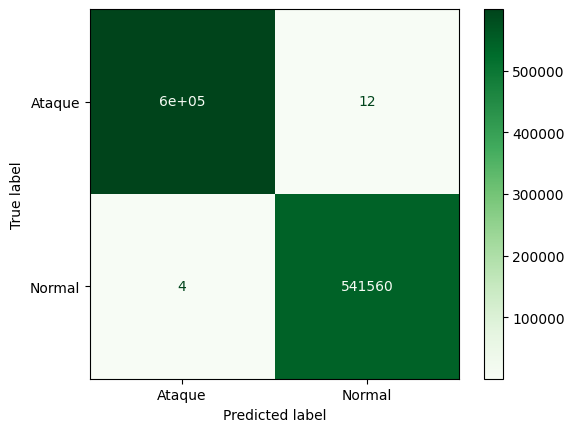

In [20]:
#Matriz de Confusão Modelo XGB Classifier
print("Matriz de Confusão Modelo XGB Classifier")
labels = ['Normal', 'Ataque']
cm = confusion_matrix(y, pred_7)
cm_inverted = cm.copy()
cm_inverted[0, 0], cm_inverted[1, 1] = cm[1, 1], cm[0, 0]  
cm_inverted[0, 1], cm_inverted[1, 0] = cm[1, 0], cm[0, 1]  
inverted_labels = labels[::-1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_inverted, display_labels=inverted_labels)
disp.plot(cmap=plt.cm.Greens)
plt.grid(False)
plt.show()

In [21]:
#Modelo Perceptron
print("Modelo Perceptron")
print()

# Realizar a validação cruzada para obter os scores de acurácia
scores = cross_val_score(model_8, X, y, cv=kfold)

# Imprimir os scores de cada fold e a média dos scores
print("Scores de cada fold:")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: ", round(score * 100 , 2))
print(f"\nMédia dos scores: {round(scores.mean() * 100, 2)}")

resultado.append(("Modelo Perceptron", round(scores.mean() * 100, 2), "{:.2e}".format(scores.std())))
print()

# Construção de um DataFrame para os resultados
print("Resultado da Média da Acurácia e do Desvio Padrão")
resultados_df = pd.DataFrame([resultado[7]], columns=['Model', 'Mean Accuracy', 'Standard Deviation'])

print(resultados_df)

print()

# Obter previsões usando cross_val_predict
pred_8 = cross_val_predict(model_8, X, y, cv=kfold)

# Calcular as métricas
precision = precision_score(y, pred_8, average='weighted')
recall = recall_score(y, pred_8, average='weighted')
f1 = f1_score(y, pred_8, average='weighted')
all_results = precision_recall_fscore_support(y, pred_8, average='weighted')

print("Métricas weighted avg")
print("Precision (weighted avg):", round(precision * 100, 2))
print("Recall (weighted avg):", round(recall * 100, 2))
print("F1 Score (weighted avg):", round(f1 * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Macro Average
precision_macro = precision_score(y, pred_8, average='macro')
recall_macro = recall_score(y, pred_8, average='macro')
f1_macro = f1_score(y, pred_8, average='macro')
all_results = precision_recall_fscore_support(y, pred_8, average='macro')

print("Métricas macro avg")
print("Precision (macro avg):", round(precision_macro * 100, 2))
print("Recall (macro avg):", round(recall_macro * 100, 2))
print("F1 Score (macro avg):", round(f1_macro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Micro Average
precision_micro = precision_score(y, pred_8, average='micro')
recall_micro = recall_score(y, pred_8, average='micro')
f1_micro = f1_score(y, pred_8, average='micro')
all_results = precision_recall_fscore_support(y, pred_8, average='micro')

print("Métricas micro avg")
print("Precision (micro avg):", round(precision_micro * 100, 2))
print("Recall (micro avg):", round(recall_micro * 100, 2))
print("F1 Score (micro avg):", round(f1_micro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

#Classification Report, Accuracy e AUC
report = classification_report(y, pred_8)
accuracy = round(accuracy_score(y, pred_8) * 100, 2)
auc = round(roc_auc_score(y, pred_8), 2) if len(np.unique(y)) > 1 else None  # Verificar se há mais de uma classe para AUC

print("Modelo Perceptron")
print(report)
print(f" Accuracy: {accuracy}%")
print(f" AUC score: {auc}")

correct8 = accuracy

Modelo Perceptron

Scores de cada fold:
Fold 1:  47.44
Fold 2:  47.27
Fold 3:  49.65
Fold 4:  47.28
Fold 5:  52.65
Fold 6:  52.56
Fold 7:  52.56
Fold 8:  52.56
Fold 9:  52.56
Fold 10:  52.56

Média dos scores: 50.71

Resultado da Média da Acurácia e do Desvio Padrão
               Model  Mean Accuracy Standard Deviation
0  Modelo Perceptron          50.71           2.37e-02

Métricas weighted avg
Precision (weighted avg): 49.89
Recall (weighted avg): 50.71
F1 Score (weighted avg): 49.08
Todos os Resultados:  (0.49892327761643684, 0.5070893966523121, 0.49078010971547853, None)

Métricas macro avg
Precision (macro avg): 49.76
Recall (macro avg): 49.79
F1 Score (macro avg): 48.54
Todos os Resultados:  (0.49756832502893933, 0.49787738526440706, 0.4853679156393892, None)

Métricas micro avg
Precision (micro avg): 50.71
Recall (micro avg): 50.71
F1 Score (micro avg): 50.71
Todos os Resultados:  (0.5070893966523121, 0.5070893966523121, 0.5070893966523121, None)

Modelo Perceptron
            

Matriz de Confusão Modelo Perceptron


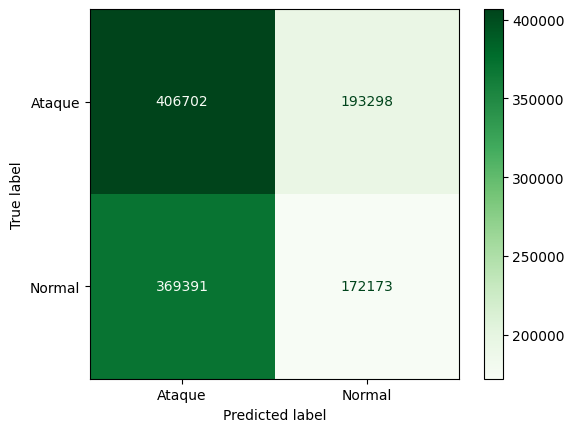

In [22]:
#Matriz de Confusão Modelo Perceptron
print("Matriz de Confusão Modelo Perceptron")
labels = ['Normal', 'Ataque']
cm = confusion_matrix(y, pred_8)
cm_inverted = cm.copy()
cm_inverted[0, 0], cm_inverted[1, 1] = cm[1, 1], cm[0, 0]  
cm_inverted[0, 1], cm_inverted[1, 0] = cm[1, 0], cm[0, 1]  
inverted_labels = labels[::-1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_inverted, display_labels=inverted_labels)
disp.plot(cmap=plt.cm.Greens)
plt.grid(False)
plt.show()

In [23]:
#Modelo MultiLayer Perceptron
print("Modelo MultiLayer Perceptron")
print()

# Realizar a validação cruzada para obter os scores de acurácia
scores = cross_val_score(model_9, X_normalized, y, cv=kfold)

# Imprimir os scores de cada fold e a média dos scores
print("Scores de cada fold:")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: ", round(score * 100 , 2))
print(f"\nMédia dos scores: {round(scores.mean() * 100, 2)}")

resultado.append(("Modelo MultiLayer Perceptron", round(scores.mean() * 100, 2), "{:.2e}".format(scores.std())))
print()

# Construção de um DataFrame para os resultados
print("Resultado da Média da Acurácia e do Desvio Padrão")
resultados_df = pd.DataFrame([resultado[8]], columns=['Model', 'Mean Accuracy', 'Standard Deviation'])

print(resultados_df)

print()

# Obter previsões usando cross_val_predict
pred_9 = cross_val_predict(model_9, X_normalized, y, cv=kfold)

# Calcular as métricas
precision = precision_score(y, pred_9, average='weighted')
recall = recall_score(y, pred_9, average='weighted')
f1 = f1_score(y, pred_9, average='weighted')
all_results = precision_recall_fscore_support(y, pred_9, average='weighted')

print("Métricas weighted avg")
print("Precision (weighted avg):", round(precision * 100, 2))
print("Recall (weighted avg):", round(recall * 100, 2))
print("F1 Score (weighted avg):", round(f1 * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Macro Average
precision_macro = precision_score(y, pred_9, average='macro')
recall_macro = recall_score(y, pred_9, average='macro')
f1_macro = f1_score(y, pred_9, average='macro')
all_results = precision_recall_fscore_support(y, pred_9, average='macro')

print("Métricas macro avg")
print("Precision (macro avg):", round(precision_macro * 100, 2))
print("Recall (macro avg):", round(recall_macro * 100, 2))
print("F1 Score (macro avg):", round(f1_macro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

# Calcular as métricas Micro Average
precision_micro = precision_score(y, pred_9, average='micro')
recall_micro = recall_score(y, pred_9, average='micro')
f1_micro = f1_score(y, pred_9, average='micro')
all_results = precision_recall_fscore_support(y, pred_9, average='micro')

print("Métricas micro avg")
print("Precision (micro avg):", round(precision_micro * 100, 2))
print("Recall (micro avg):", round(recall_micro * 100, 2))
print("F1 Score (micro avg):", round(f1_micro * 100, 2))
print("Todos os Resultados: ", all_results)
print()

#Classification Report, Accuracy e AUC
report = classification_report(y, pred_9)
accuracy = round(accuracy_score(y, pred_9) * 100, 2)
auc = round(roc_auc_score(y, pred_9), 2) if len(np.unique(y)) > 1 else None  # Verificar se há mais de uma classe para AUC

print("Modelo MultiLayer Perceptron")
print(report)
print(f" Accuracy: {accuracy}%")
print(f" AUC score: {auc}")

correct9 = accuracy

Modelo MultiLayer Perceptron

Scores de cada fold:
Fold 1:  70.18
Fold 2:  38.81
Fold 3:  67.45
Fold 4:  77.67
Fold 5:  56.17
Fold 6:  89.11
Fold 7:  99.97
Fold 8:  99.98
Fold 9:  99.96
Fold 10:  99.97

Média dos scores: 79.93

Resultado da Média da Acurácia e do Desvio Padrão
                          Model  Mean Accuracy Standard Deviation
0  Modelo MultiLayer Perceptron          79.93           2.05e-01

Métricas weighted avg
Precision (weighted avg): 79.93
Recall (weighted avg): 79.93
F1 Score (weighted avg): 79.93
Todos os Resultados:  (0.7992615134593561, 0.7992946518986233, 0.7992755010462286, None)

Métricas macro avg
Precision (macro avg): 79.88
Recall (macro avg): 79.87
F1 Score (macro avg): 79.87
Todos os Resultados:  (0.7987892017917924, 0.7986751840102617, 0.79872959899231, None)

Métricas micro avg
Precision (micro avg): 79.93
Recall (micro avg): 79.93
F1 Score (micro avg): 79.93
Todos os Resultados:  (0.7992946518986233, 0.7992946518986233, 0.7992946518986233, None)

Mod

Matriz de Confusão Modelo MultiLayer Perceptron


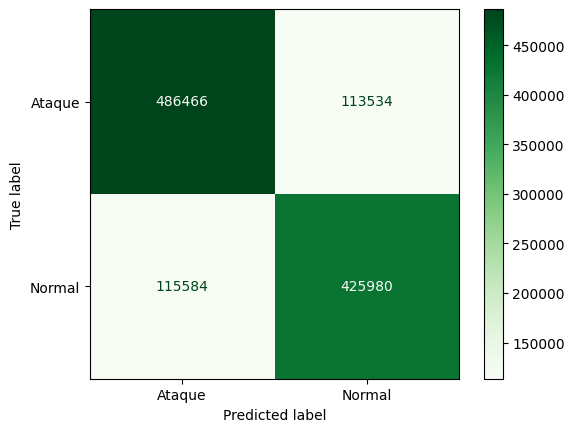

In [24]:
#Matriz de Confusão Modelo MultiLayer Perceptron
print("Matriz de Confusão Modelo MultiLayer Perceptron")
labels = ['Normal', 'Ataque']
cm = confusion_matrix(y, pred_9)
cm_inverted = cm.copy()
cm_inverted[0, 0], cm_inverted[1, 1] = cm[1, 1], cm[0, 0]  
cm_inverted[0, 1], cm_inverted[1, 0] = cm[1, 0], cm[0, 1]  
inverted_labels = labels[::-1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_inverted, display_labels=inverted_labels)
disp.plot(cmap=plt.cm.Greens)
plt.grid(False)
plt.show()

In [25]:
# Comparação de Modelos
model_compare = pd.DataFrame(list(zip(y, pred_1, pred_2, pred_3, pred_4, pred_5, pred_6, pred_7, pred_8, pred_9)), 
                             columns=['Label', 'RandomForest', 'DecisionTree', 'SGDClassifier', 'LogisticRegression', 'K-NN', 'Naive Bayes', 'XGB Classifier', 'Perceptron','MultiLayer Perceptron'])
population = model_compare.shape[0]

# Contagem de classificações corretas e falsas para o modelo RandomForest
correct_count = np.sum(model_compare['RandomForest'] == model_compare['Label'])
false_count = population - correct_count

# Porcentagem de classificações corretas para o modelo RandomForest
correct_percentage = correct_count * 100 / population

print('Contagem de Corretos e Falsos: Random Forest')
print('Classificações corretas: {} - Classificações incorretas: {}'.format(correct_count, false_count))
print('Porcentagem de classificações corretas: {:.2f}%'.format(correct_percentage))
print()

# Contagem de classificações corretas e falsas para o modelo DecisionTree
correct_count = np.sum(model_compare['DecisionTree'] == model_compare['Label'])
false_count = population - correct_count

# Porcentagem de classificações corretas para o modelo DecisionTree
correct_percentage = correct_count * 100 / population
print('Contagem de Corretos e Falsos: Decision Tree')
print('Classificações corretas: {} - Classificações incorretas: {}'.format(correct_count, false_count))
print('Porcentagem de classificações corretas: {:.2f}%'.format(correct_percentage)) 
print()

# Contagem de classificações corretas e falsas para o modelo SGDClassifier
correct_count = np.sum(model_compare['SGDClassifier'] == model_compare['Label'])
false_count = population - correct_count

# Porcentagem de classificações corretas para o modelo SGDClassifier
correct_percentage = correct_count * 100 / population

print('Contagem de Corretos e Falsos: SGDClassifier')
print('Classificações corretas: {} - Classificações incorretas: {}'.format(correct_count, false_count))
print('Porcentagem de classificações corretas: {:.2f}%'.format(correct_percentage))
print()

# Contagem de classificações corretas e falsas para o modelo Logistic Regression
correct_count = np.sum(model_compare['LogisticRegression'] == model_compare['Label'])
false_count = population - correct_count

# Porcentagem de classificações corretas para o modelo Logistic Regression
correct_percentage = correct_count * 100 / population

print('Contagem de Corretos e Falsos: Logistic Regression')
print('Classificações corretas: {} - Classificações incorretas: {}'.format(correct_count, false_count))
print('Porcentagem de classificações corretas: {:.2f}%'.format(correct_percentage))
print()

# Contagem de classificações corretas e falsas para o K-NN
correct_count = np.sum(model_compare['K-NN'] == model_compare['Label'])
false_count = population - correct_count

# Porcentagem de classificações corretas para o modelo K-NN
correct_percentage = correct_count * 100 / population

print('Contagem de Corretos e Falsos: K-NN')
print('Classificações corretas: {} - Classificações incorretas: {}'.format(correct_count, false_count))
print('Porcentagem de classificações corretas: {:.2f}%'.format(correct_percentage))  
print() 

# Contagem de classificações corretas e falsas para o Naive Bayes
correct_count = np.sum(model_compare['Naive Bayes'] == model_compare['Label'])
false_count = population - correct_count

# Porcentagem de classificações corretas para o modelo Naive Bayes
correct_percentage = correct_count * 100 / population

print('Contagem de Corretos e Falsos: Naive Bayes')
print('Classificações corretas: {} - Classificações incorretas: {}'.format(correct_count, false_count))
print('Porcentagem de classificações corretas: {:.2f}%'.format(correct_percentage)) 
print()

# Contagem de classificações corretas e falsas para o XGB Classifier
correct_count = np.sum(model_compare['XGB Classifier'] == model_compare['Label'])
false_count = population - correct_count

# Porcentagem de classificações corretas para o modelo XGB Classifier
correct_percentage = correct_count * 100 / population

print('Contagem de Corretos e Falsos: XGB Classifier')
print('Classificações corretas: {} - Classificações incorretas: {}'.format(correct_count, false_count))
print('Porcentagem de classificações corretas: {:.2f}%'.format(correct_percentage)) 
print()  

# Contagem de classificações corretas e falsas para o Perceptron
correct_count = np.sum(model_compare['Perceptron'] == model_compare['Label'])
false_count = population - correct_count

# Porcentagem de classificações corretas para o modelo Perceptron
correct_percentage = correct_count * 100 / population

print('Contagem de Corretos e Falsos: Perceptron')
print('Classificações corretas: {} - Classificações incorretas: {}'.format(correct_count, false_count))
print('Porcentagem de classificações corretas: {:.2f}%'.format(correct_percentage))
print()

# Contagem de classificações corretas e falsas para o MultiLayer Perceptron
correct_count = np.sum(model_compare['MultiLayer Perceptron'] == model_compare['Label'])
false_count = population - correct_count

# Porcentagem de classificações corretas para o modelo MultiLayer Perceptron
correct_percentage = correct_count * 100 / population

print('Contagem de Corretos e Falsos: MultiLayer Perceptron')
print('Classificações corretas: {} - Classificações incorretas: {}'.format(correct_count, false_count))
print('Porcentagem de classificações corretas: {:.2f}%'.format(correct_percentage))

Contagem de Corretos e Falsos: Random Forest
Classificações corretas: 1141194 - Classificações incorretas: 370
Porcentagem de classificações corretas: 99.97%

Contagem de Corretos e Falsos: Decision Tree
Classificações corretas: 1141220 - Classificações incorretas: 344
Porcentagem de classificações corretas: 99.97%

Contagem de Corretos e Falsos: SGDClassifier
Classificações corretas: 565041 - Classificações incorretas: 576523
Porcentagem de classificações corretas: 49.50%

Contagem de Corretos e Falsos: Logistic Regression
Classificações corretas: 679817 - Classificações incorretas: 461747
Porcentagem de classificações corretas: 59.55%

Contagem de Corretos e Falsos: K-NN
Classificações corretas: 988299 - Classificações incorretas: 153265
Porcentagem de classificações corretas: 86.57%

Contagem de Corretos e Falsos: Naive Bayes
Classificações corretas: 734635 - Classificações incorretas: 406929
Porcentagem de classificações corretas: 64.35%

Contagem de Corretos e Falsos: XGB Classifi

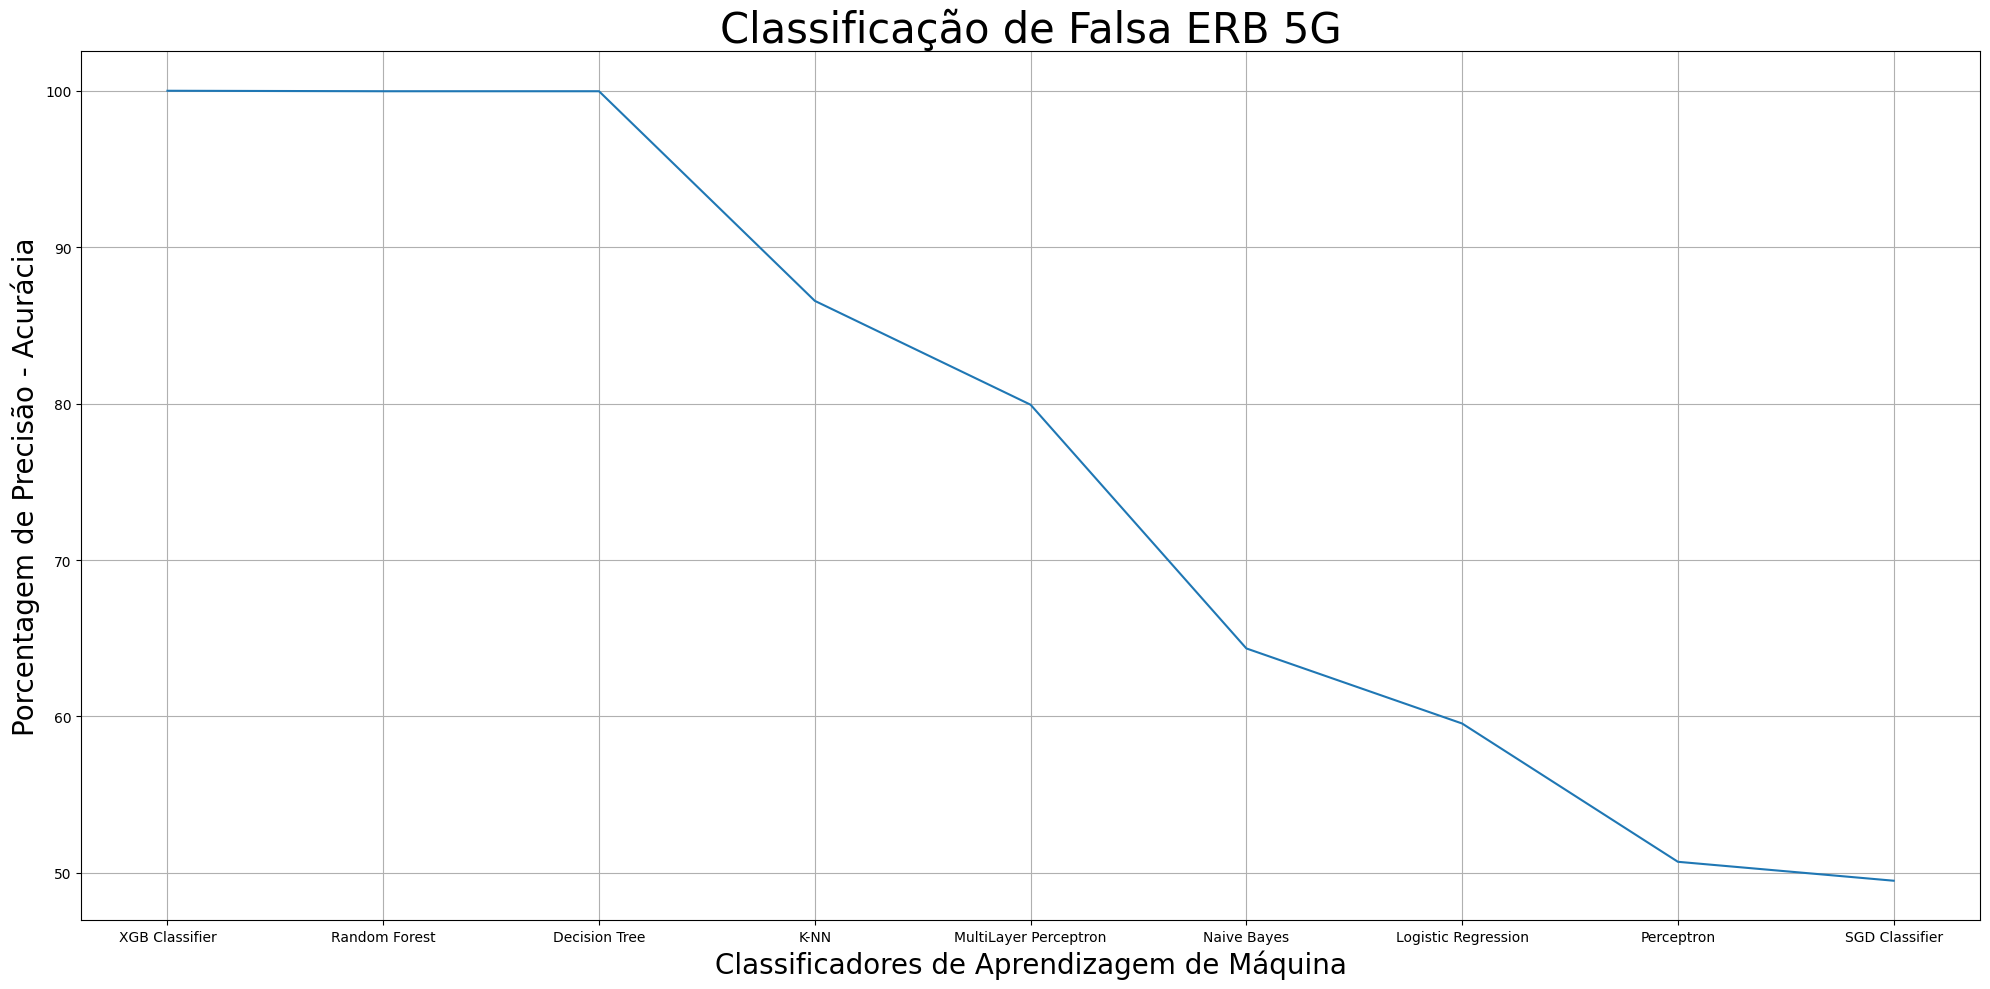

In [26]:
#Plotagem do Gráfico Comparativo Valores
acc = {'Random Forest' : correct1, 'Decision Tree' : correct2, 'SGD Classifier' : correct3, 'Logistic Regression' : correct4, 'K-NN': correct5, 'Naive Bayes': correct6, 'XGB Classifier': correct7, 'Perceptron': correct8, 'MultiLayer Perceptron': correct9}
acc = sorted(acc.items(), key = lambda x: x[1], reverse = True)
acc = dict(acc)

plt.figure(figsize = [20, 10])
plt.plot(acc.keys(), acc.values())
plt.ylabel('Porcentagem de Precisão - Acurácia', fontsize = 20)
plt.xlabel('Classificadores de Aprendizagem de Máquina', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Classificação de Falsa ERB 5G',fontsize = 30)
plt.grid()
plt.tight_layout()
plt.show()

In [27]:
# Construção de um DataFrame para os resultados
print("Resultados dos Modelos")
resultados_df = pd.DataFrame(resultado, columns=['Model', 'Mean Accuracy', 'Standard Deviation'])

print(resultados_df)

Resultados dos Modelos
                          Model  Mean Accuracy Standard Deviation
0          Modelo Random Forest          99.97           8.62e-04
1          Modelo Decision Tree          99.97           8.69e-04
2         Modelo SGD Classifier          49.50           5.39e-02
3    Modelo Logistic Regression          59.55           1.49e-01
4                   Modelo K-NN          86.57           1.02e-01
5            Modelo Naive Bayes          64.35           1.58e-01
6         Modelo XGB Classifier         100.00           1.67e-05
7             Modelo Perceptron          50.71           2.37e-02
8  Modelo MultiLayer Perceptron          79.93           2.05e-01


In [28]:
print("Aprendizado Finalizado!!!")

Aprendizado Finalizado!!!
